# TensorFlow Time Series Predictions

Play with the same data as linear regressions.

## Get Basic Setup Done

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import util

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

## Generate Test Data

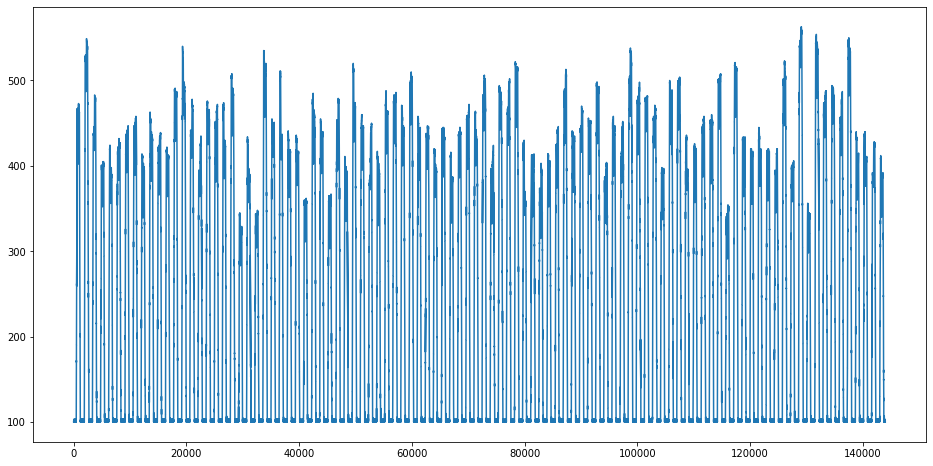

In [34]:
# Number of days to generate data for
DAYS = 100

# generate a numpy array of raw data first
d = util.gen_data(days=DAYS)

# turn it into a pandas data frame
df = pd.DataFrame({'Time': d[:, 0], 'ACEs': d[:, 1]})

# plot just the ACEs series
plt.plot(df['ACEs'])

## Univariate Data Extraction

This function takes in a 1D dataset of values (`dataset`) and carves it up into two different returns:

- An array of arrays of length `history_size` of overlapping data, starting with the data at `start_index`, ending at `end_index`.
- A simple array of future values that are `target_size` ticks in the future from each of the arrays above that are effectively the value we're trying to train to/for.

So, for setting `target_size`, consider how far into the future you want to predict, and for `history_size` consider how much of past history you want to consider.

In [35]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    '''
    * dataset the 1D array of data
    * start_index where in dataset to get data from
    * end_index last index to take data from
    * history_size size of past window of information
    * target_size how far in the future to predict
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x17f44d3d0>],
      dtype=object)

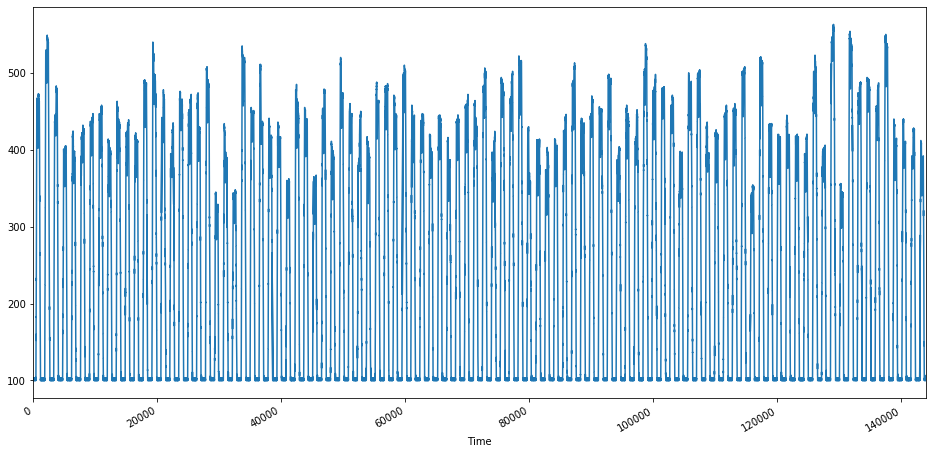

In [36]:
uni_data = df['ACEs']
uni_data.index = df['Time']
uni_data.plot(subplots=True)

## Normalize Data

Mean    = 239.61155555555555
Std Dev = 154.7192315043822


array([<matplotlib.axes._subplots.AxesSubplot object at 0x17dc17dd0>],
      dtype=object)

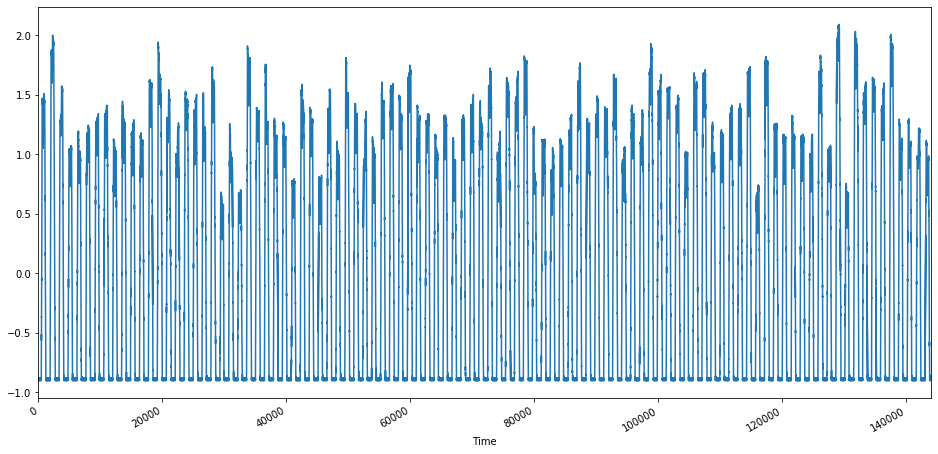

In [37]:
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()

print('Mean    = {}'.format(uni_train_mean))
print('Std Dev = {}'.format(uni_train_std))

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data.plot(subplots=True)

## Prepare Data

In [38]:
uni_data_vals = uni_data.values

# uses the past "day" for history (one tick is one minute)
# univariate_past_history = 1440

# try 30 minutes of history
univariate_past_history = 30

# predict 1 minute ahead
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_vals, 0, 1440*(DAYS-2),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_vals, 1440*(DAYS-2), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
print(x_train_uni.shape)
print(x_train_uni)
print(y_train_uni.shape)
print(y_train_uni)

(141090, 30, 1)
[[[-0.90861629]
  [-0.89619011]
  [-0.9024032 ]
  ...
  [-0.90861629]
  [-0.90861629]
  [-0.90861629]]

 [[-0.89619011]
  [-0.9024032 ]
  [-0.90861629]
  ...
  [-0.90861629]
  [-0.90861629]
  [-0.90861629]]

 [[-0.9024032 ]
  [-0.90861629]
  [-0.88997701]
  ...
  [-0.90861629]
  [-0.90861629]
  [-0.90861629]]

 ...

 [[-0.90861629]
  [-0.88997701]
  [-0.90861629]
  ...
  [-0.90861629]
  [-0.90861629]
  [-0.88997701]]

 [[-0.88997701]
  [-0.90861629]
  [-0.90861629]
  ...
  [-0.90861629]
  [-0.88997701]
  [-0.90861629]]

 [[-0.90861629]
  [-0.90861629]
  [-0.88997701]
  ...
  [-0.88997701]
  [-0.90861629]
  [-0.90861629]]]
(141090,)
[-0.90861629 -0.90861629 -0.90861629 ... -0.90861629 -0.90861629
 -0.90861629]


In [8]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.90861629]
 [-0.89619011]
 [-0.9024032 ]
 [-0.90861629]
 [-0.88997701]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.88997701]
 [-0.89619011]
 [-0.89619011]
 [-0.9024032 ]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]
 [-0.88997701]
 [-0.9024032 ]
 [-0.9024032 ]
 [-0.89619011]
 [-0.90861629]
 [-0.88997701]
 [-0.90861629]
 [-0.90861629]
 [-0.90861629]]

 Target temperature to predict
-0.9086162946598285


In [9]:
def create_time_steps(length):
    return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gx', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

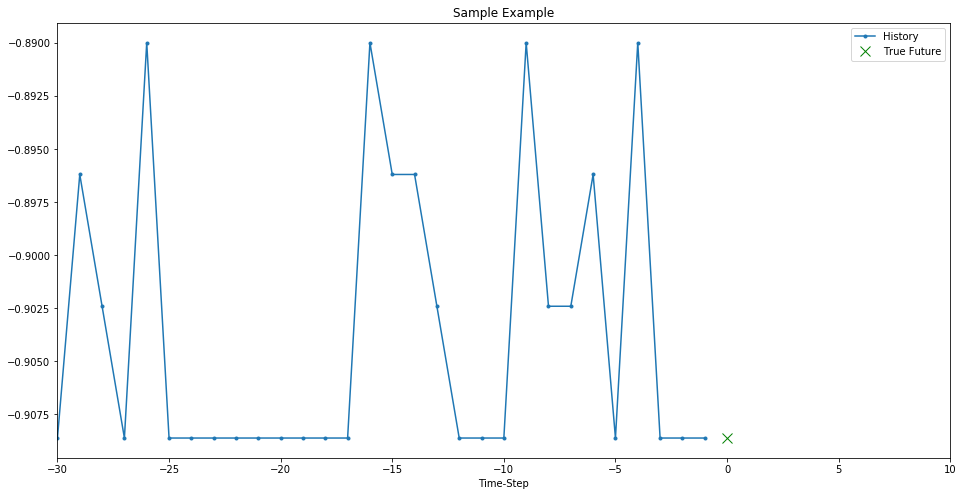

In [11]:
# for i in range(0, 1000, 100):

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

## Take Average of Last Day of Observations & Predict

In [12]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/einarnn/.virtualenvs/a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

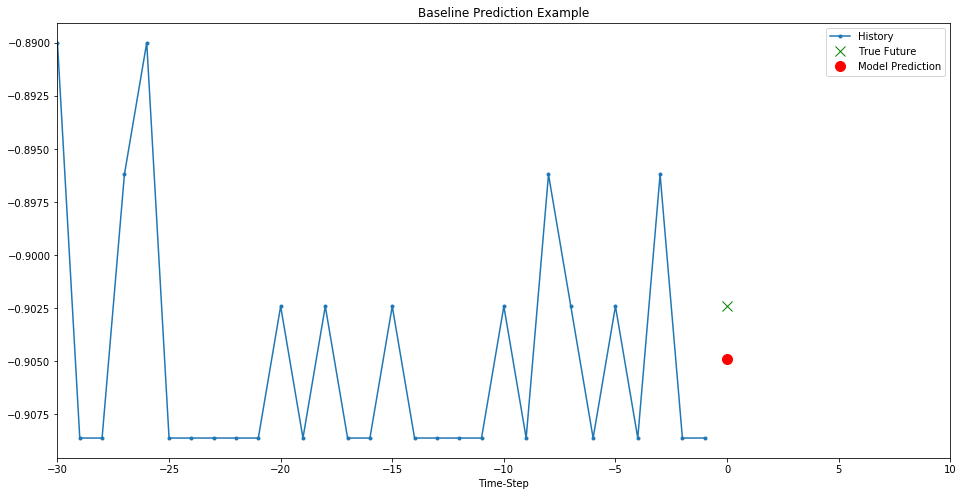

In [13]:
show_plot([x_train_uni[200], y_train_uni[200], baseline(x_train_uni[200])], 0, 'Baseline Prediction Example')

This is really not a very good prediction mechanism!!

## Recurrent Neural Network

In [14]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(141090, 30, 1)
(141090,)


### Batch Up The Data Into TF Data Structures

In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

### Compile The Model

First, define a function to create and compile the model.

In [17]:
#
# single layer
#
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(15, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.Dense(1)
#])

BREADTH = 30

#
# create and compile a model
#
def create_model(breadth=BREADTH, input_shape=None):
    retval = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(BREADTH, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(BREADTH, return_sequences=True),
        tf.keras.layers.LSTM(BREADTH),
        tf.keras.layers.Dense(1)
    ])
    retval.compile(optimizer='adam', loss='mae')
    return retval    

Then create an actual instance:

In [18]:
simple_lstm_model = create_model(input_shape=x_train_uni.shape[-2:])

Take a look at what a prediuction will give you by taking one window from the validation set and calling `predict`:

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Now we can train the model if we want. But skip this if you just want to load pre-created weights:

In [ ]:
EVALUATION_INTERVAL = 500  # original 200
VALIDATION_STEPS    = 50   # original 50
EPOCHS              = 50   # original 5

history_lstm = simple_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=VALIDATION_STEPS)

Save the weights. Again, don't do this if we're loading a predefined set of weights.

In [ ]:
simple_lstm_model.save_weights('save_lstm')

Load a predefined set of weights. Note that the model definition really needs top be the same, so look out for that,. noting that some weights files will load into a model that is not the same; seems to happen when you have more layers in the model you trained than you are loading into:

In [21]:
loaded_lstm_model = create_model(input_shape=x_train_uni.shape[-2:])
loaded_lstm_model.load_weights('save_lstm')

In [22]:
loaded_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


## Do Some Sample Predictions

This loop will display a plot per prediction.

(30, 1)
()
[-0.9032339]


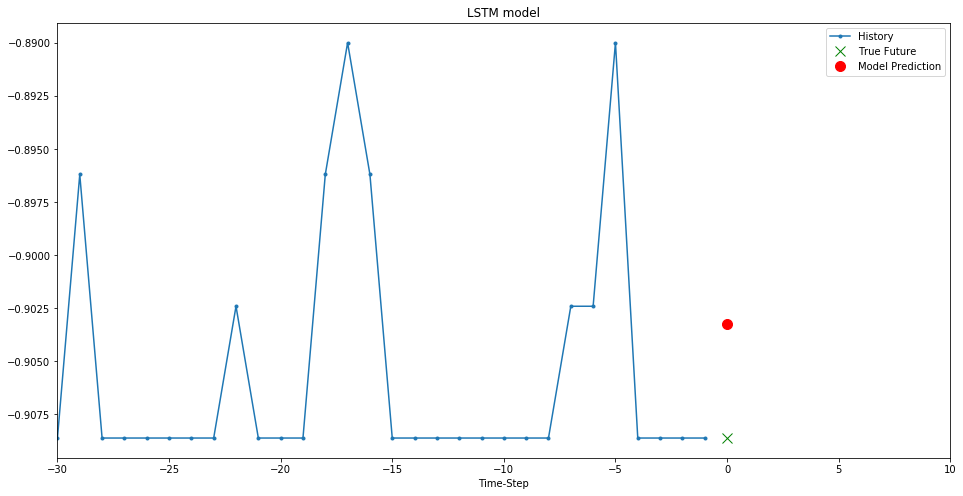

(30, 1)
()
[-0.9035273]


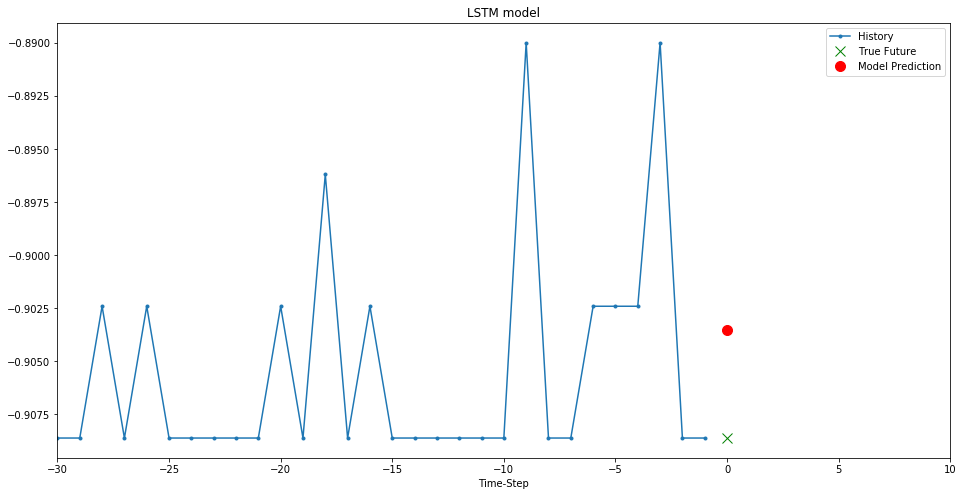

(30, 1)
()
[0.49440557]


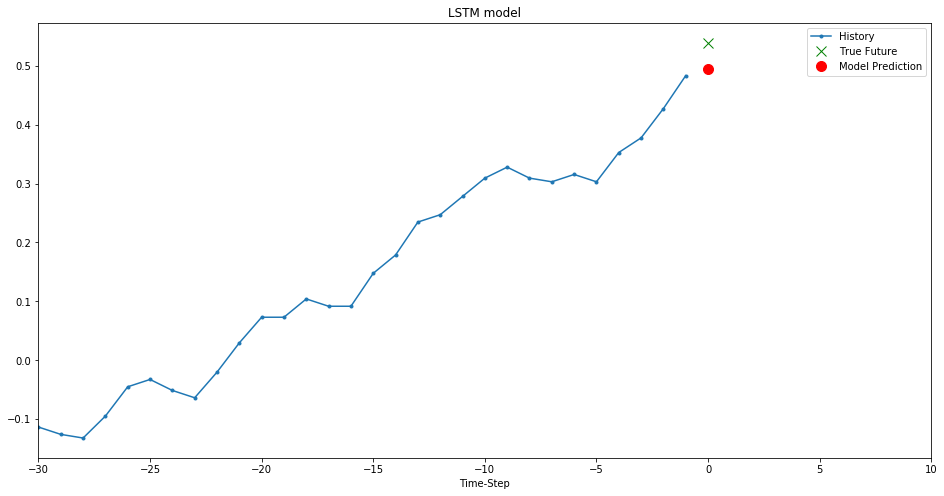

(30, 1)
()
[1.0221041]


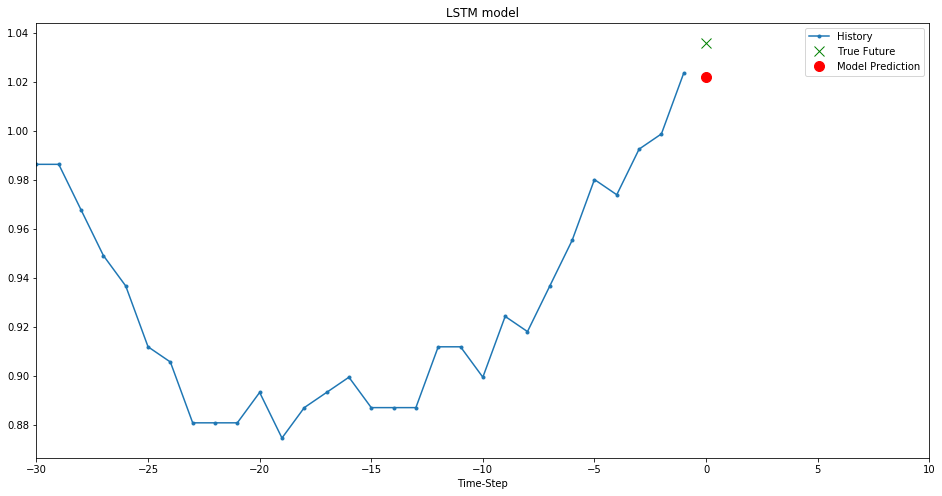

(30, 1)
()
[0.85480505]


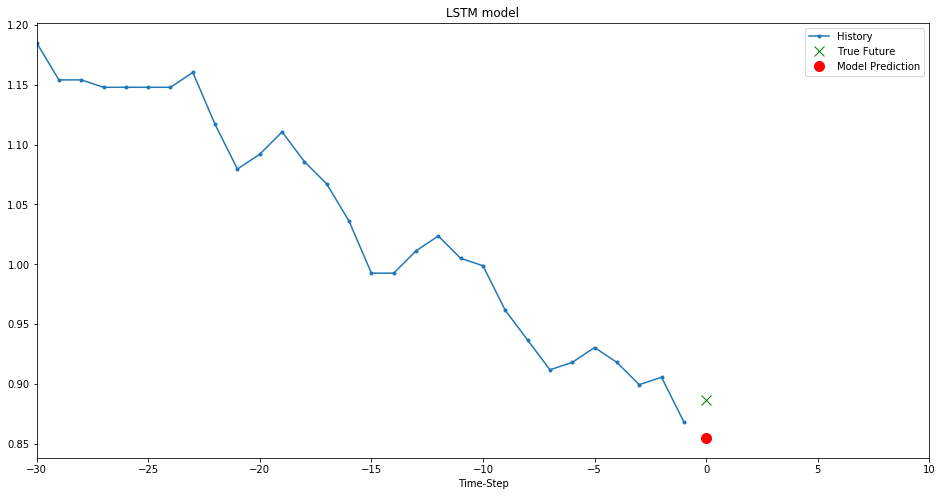

(30, 1)
()
[-0.90289795]


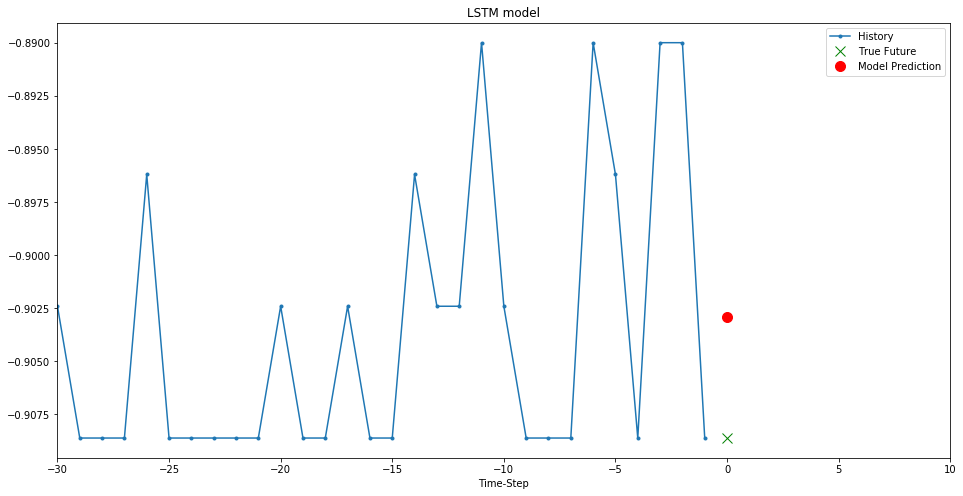

(30, 1)
()
[-0.9024944]


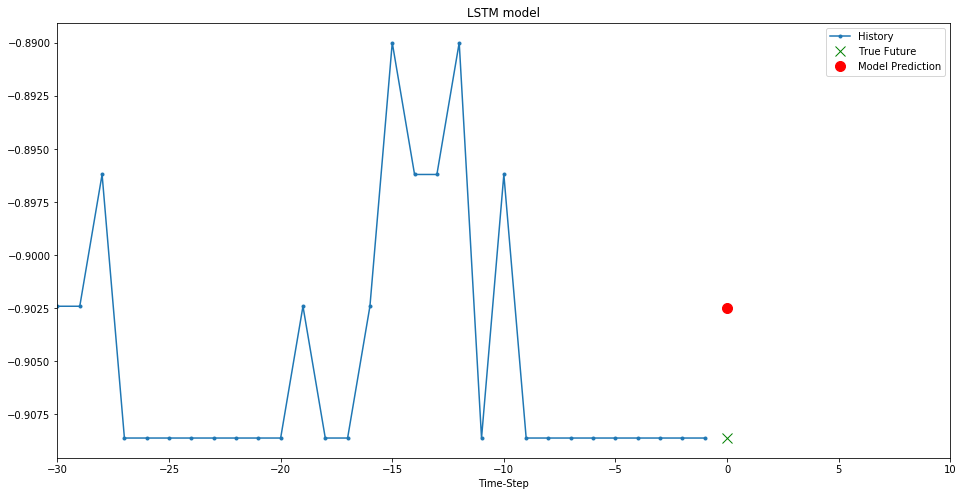

(30, 1)
()
[-0.9033362]


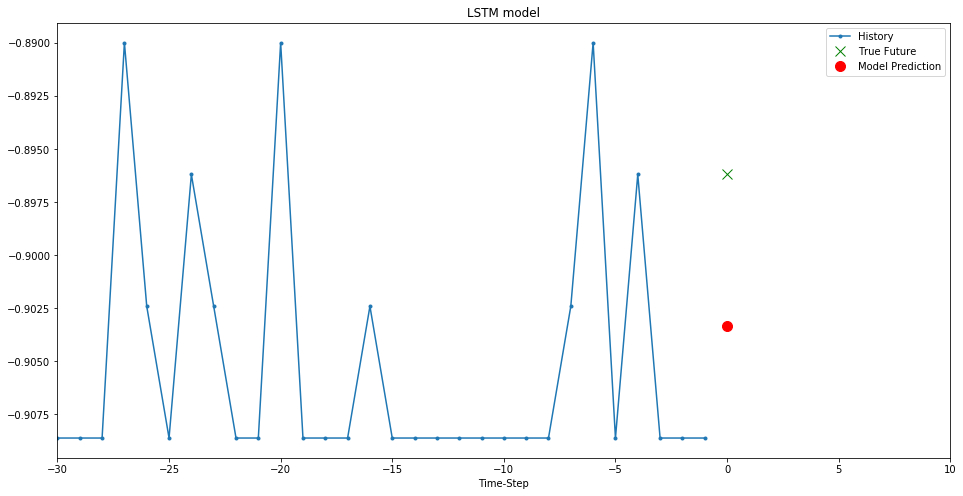

(30, 1)
()
[1.6158503]


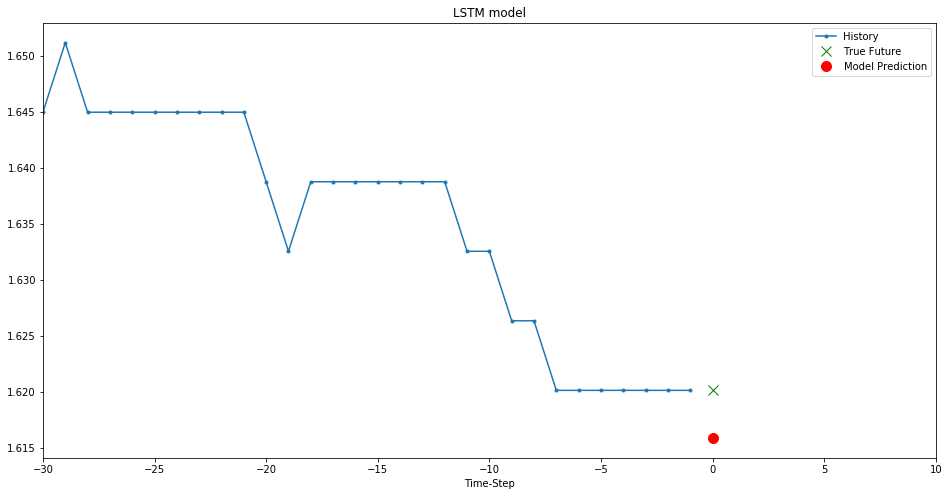

(30, 1)
()
[1.5407497]


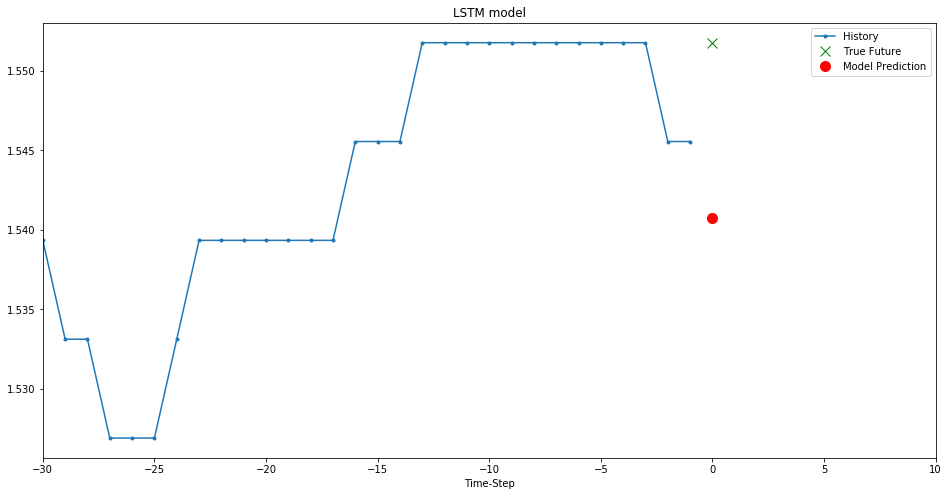

(30, 1)
()
[0.25021476]


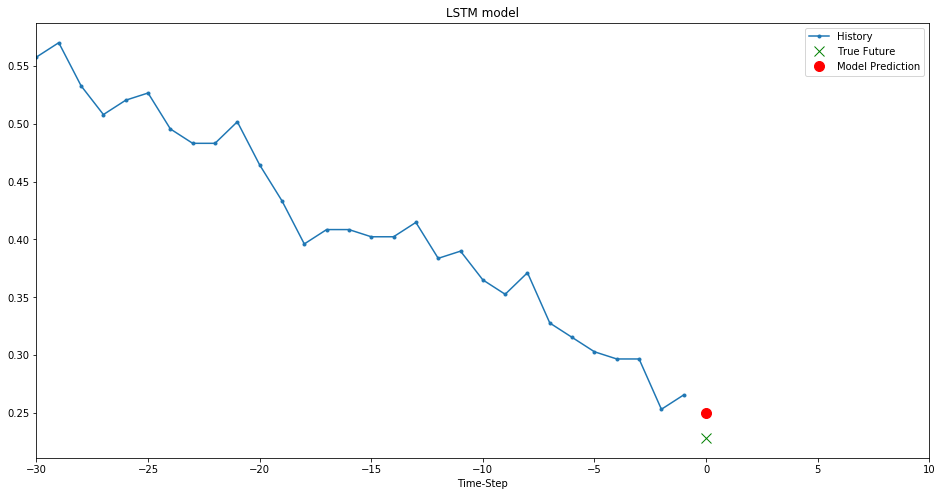

(30, 1)
()
[-0.9029369]


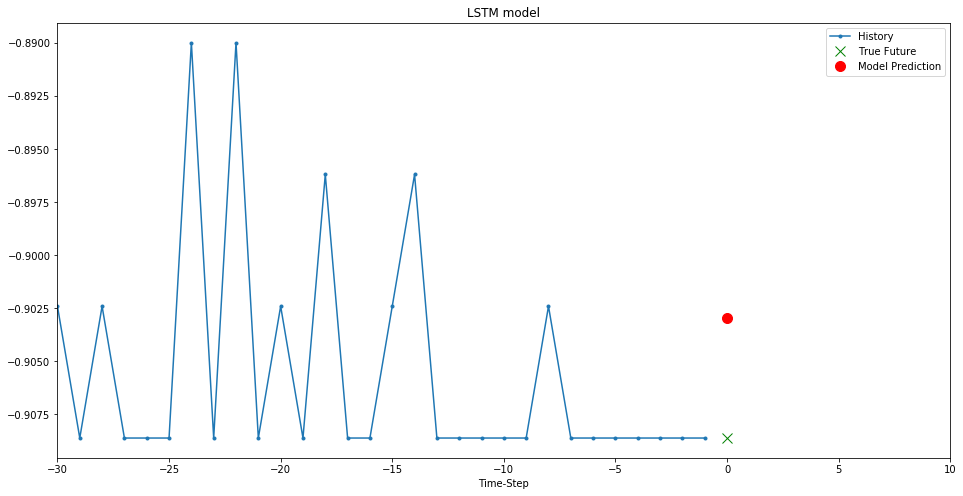

(30, 1)
()
[-0.9032339]


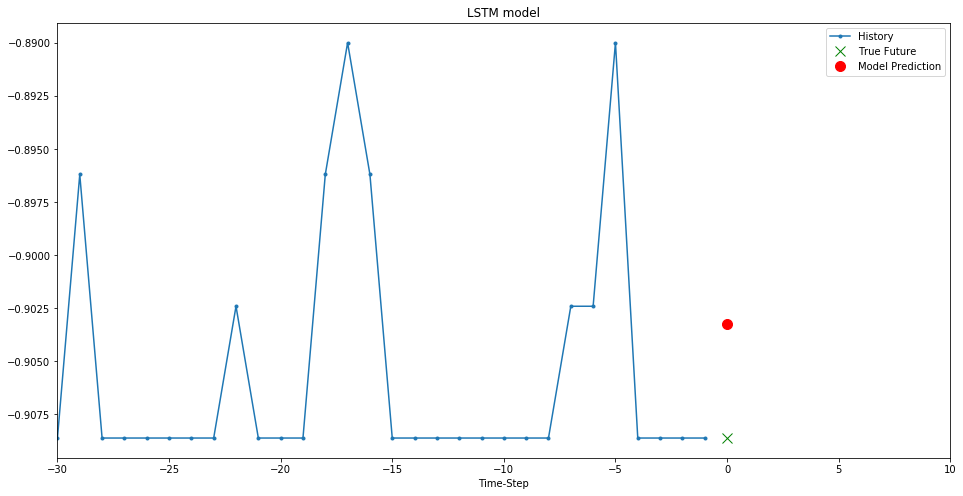

(30, 1)
()
[-0.9035273]


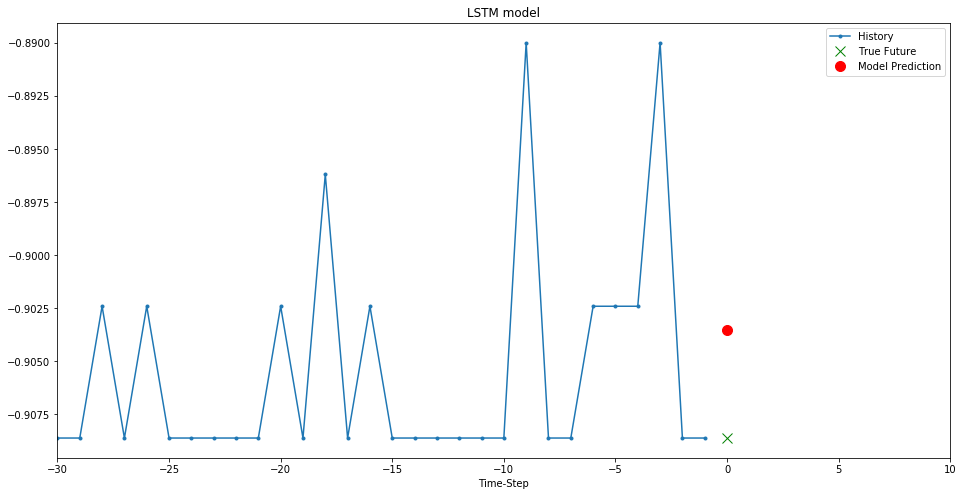

(30, 1)
()
[0.49440557]


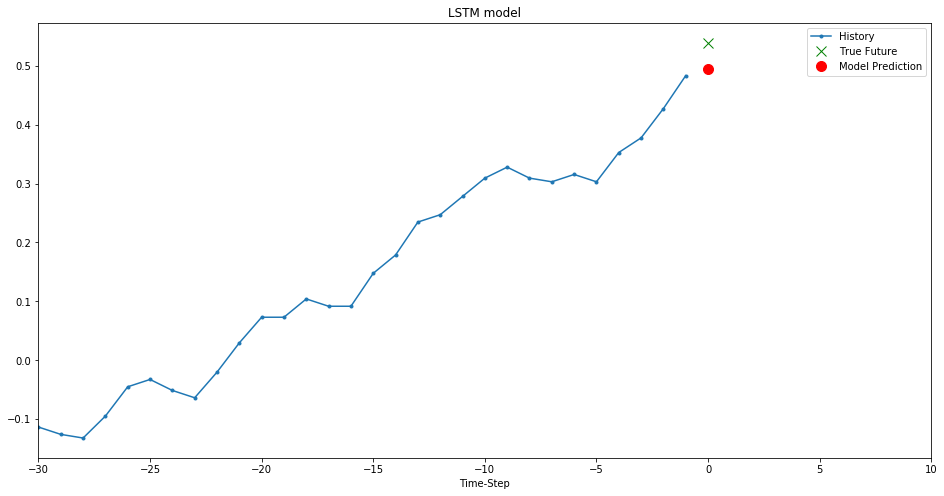

(30, 1)
()
[1.0221041]


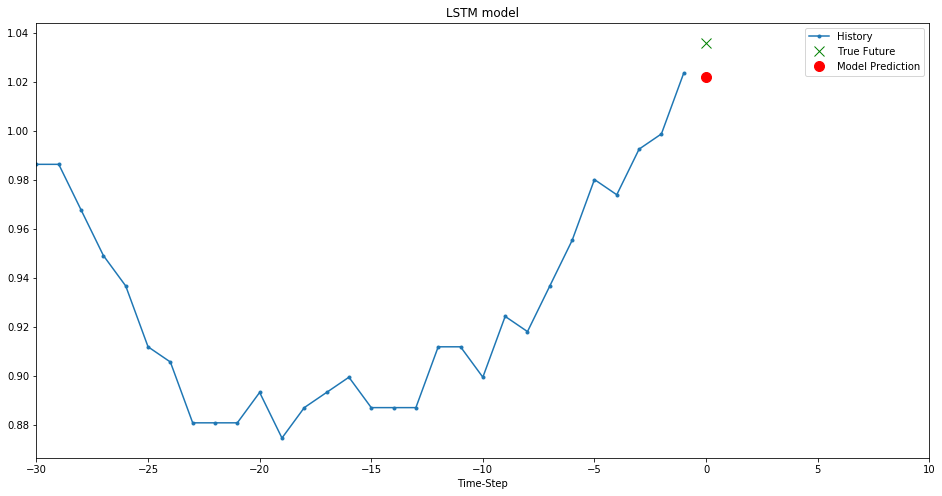

(30, 1)
()
[0.85480505]


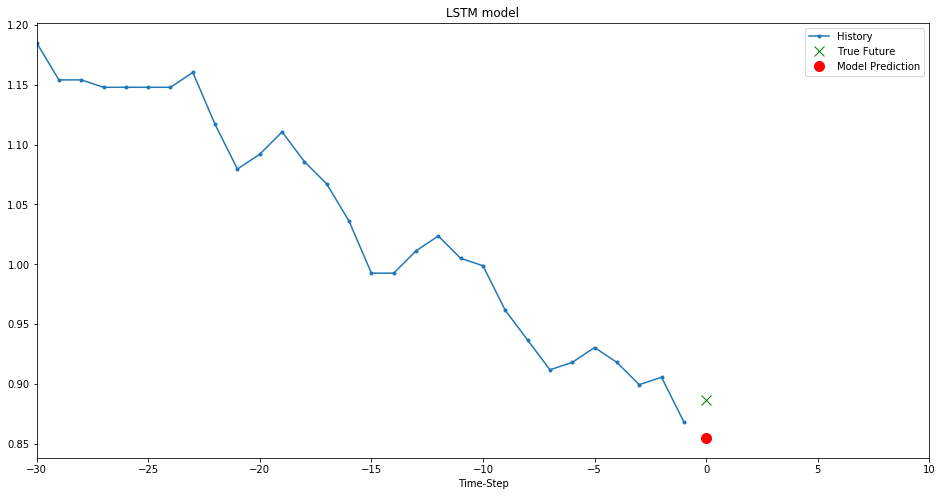

(30, 1)
()
[-0.90289795]


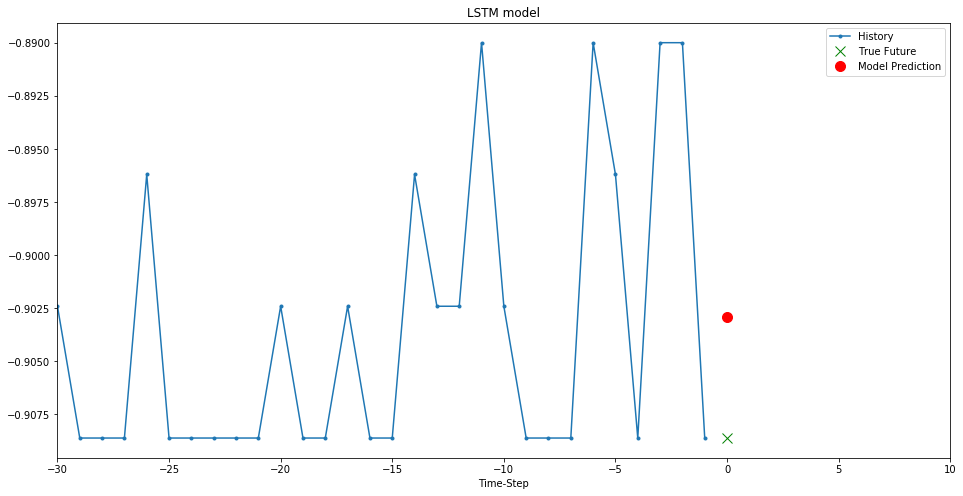

(30, 1)
()
[-0.9024944]


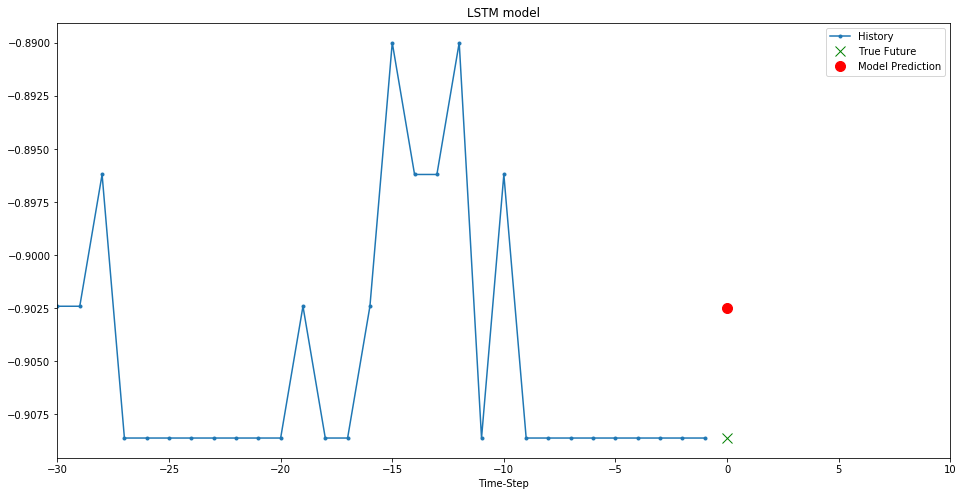

(30, 1)
()
[-0.9033362]


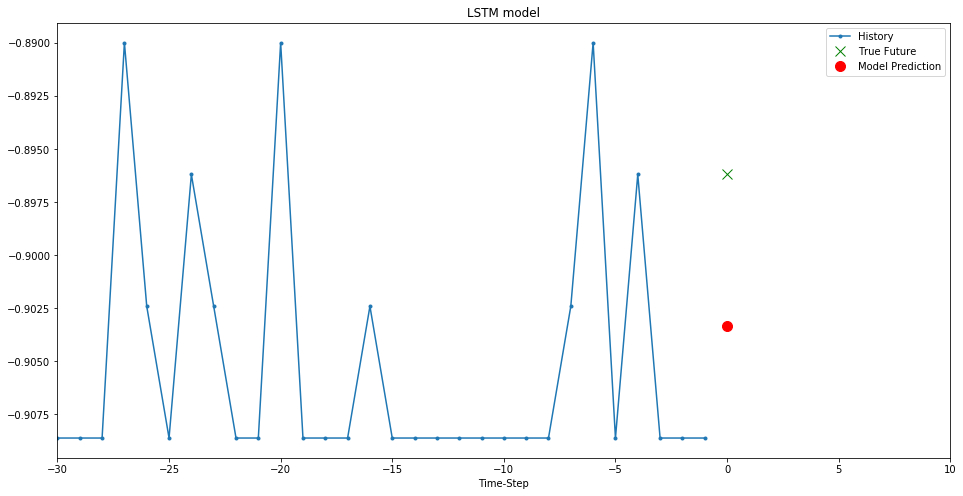

(30, 1)
()
[1.6158503]


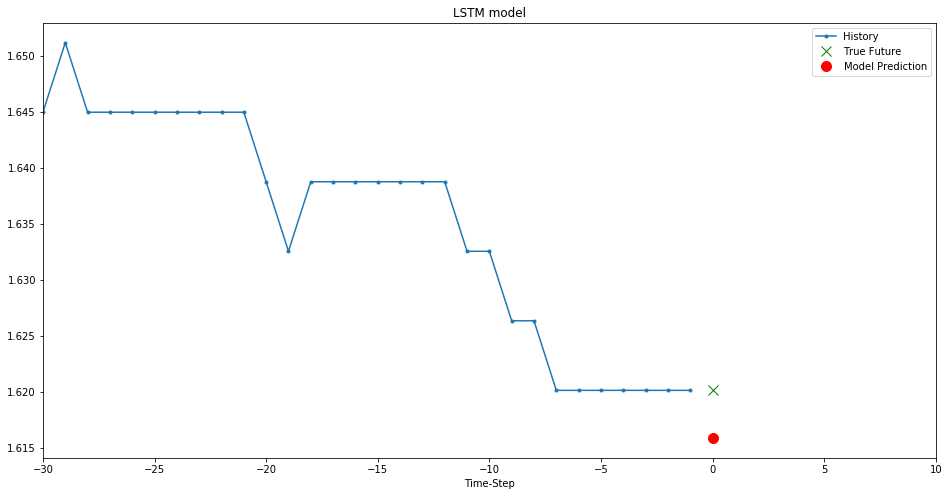

(30, 1)
()
[1.5407497]


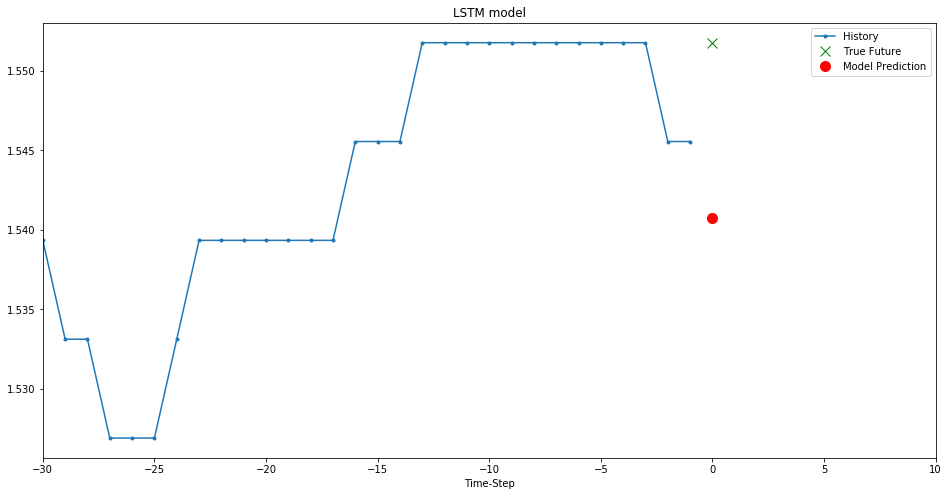

(30, 1)
()
[0.25021476]


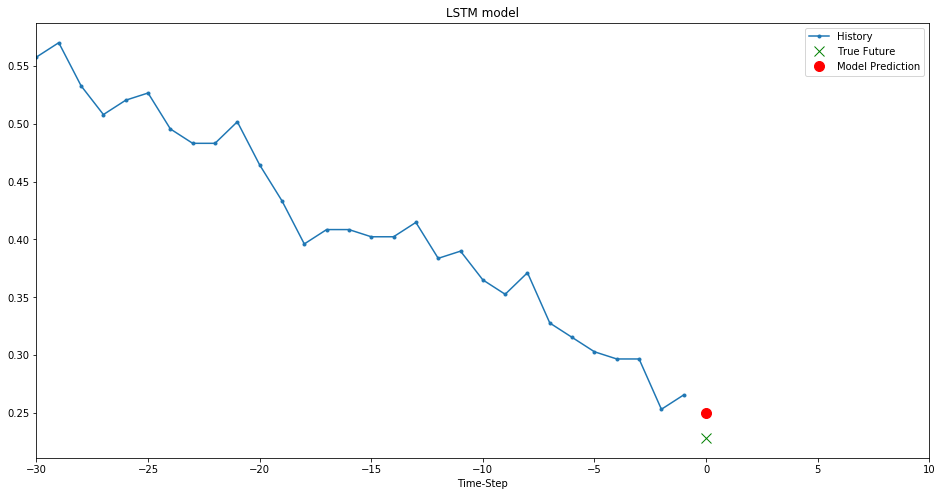

(30, 1)
()
[-0.9029369]


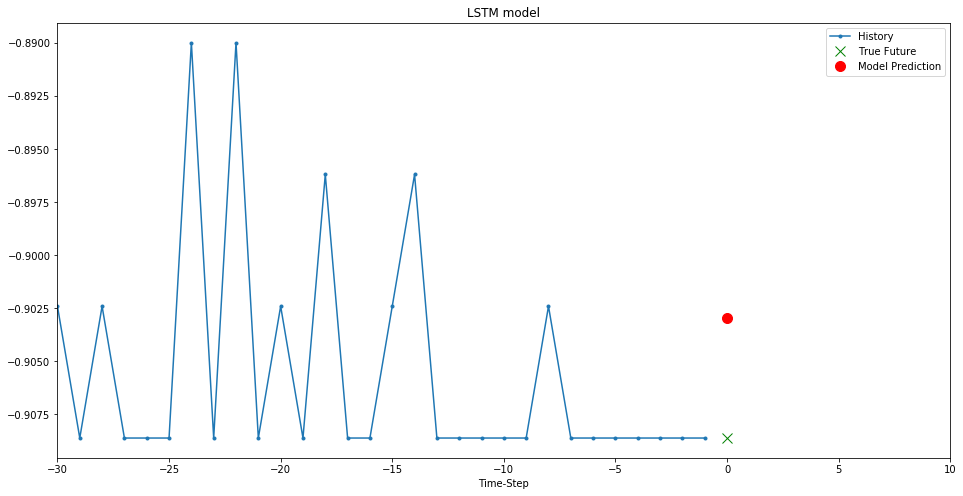

(30, 1)
()
[-0.9032339]


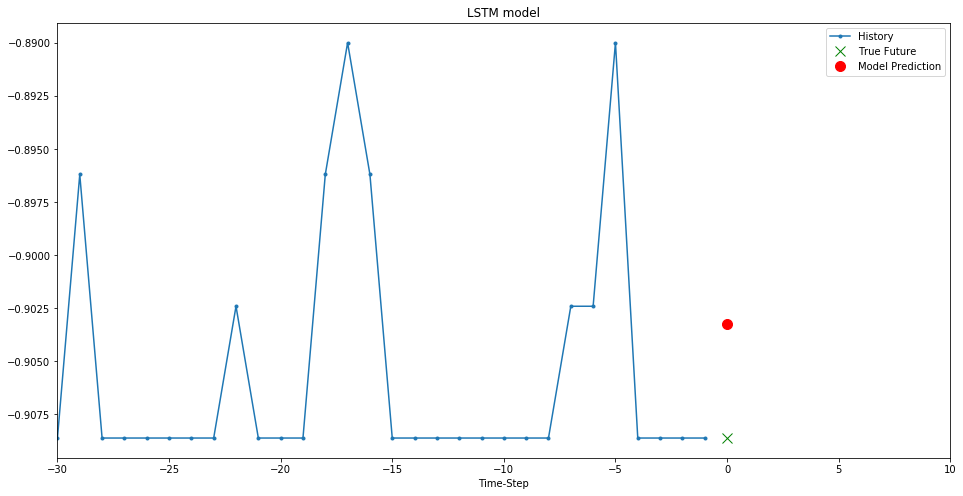

In [39]:
# lstm_model = simple_lstm_model
lstm_model = loaded_lstm_model

for x, y in val_univariate.take(25):
    print(x[0].numpy().shape)
    print(y[0].numpy().shape)
    pred = lstm_model.predict(x)[0]
    print(pred)
    plot = show_plot([x[0].numpy(), y[0].numpy(), lstm_model.predict(x)[0]], 0, 'LSTM model')
    plot.show()

# Calculate Mean Squared Errors

Simnple MSE calculation against a random selection of the validation data created earlier.

In [43]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# lstm_model = simple_lstm_model
lstm_model = loaded_lstm_model

real = []
predictions = []
for x, y in tqdm(val_univariate.take(250)):
    
    # predicted value, scaled back up
    predictions.append(lstm_model.predict(x)[0][0] * uni_train_std + uni_train_mean)
    
    # real value, scaled back up
    real.append(y[0].numpy() * uni_train_std + uni_train_mean)

error = mean_squared_error(real, predictions)
print('Test MSE : %.9f' % error)

250it [00:18, 13.30it/s]

Test MSE : 8.087559160


# Scratch Area

In [ ]:
dataset = df
start_index = 0
end_index = 1440 * 3
history_size = 1440
target_size = 0

data = []
labels = []

start_index = start_index + history_size
if end_index is None:
    end_index = len(dataset) - target_size

for i in range(start_index, end_index):
    print('i', i)
    indices = range(i-history_size, i)
    print('indices', indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

np.array(data), np.array(labels)

In [ ]:
dataset['Time']